# Importing necessecary libraries and models

In [141]:
# for loading/processing the images  
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from sklearn.cluster import KMeans

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics 

In [2]:
import pandas as pd
df=pd.read_excel("(English translate)20210426_image_classification_Imbesideyou (1).xlsx")

In [3]:
df.describe()

Unnamed: 0
count         0.0
mean          NaN
std           NaN
min           NaN
25%           NaN
50%           NaN
75%           NaN
max           NaN

# changing column names for ease 

In [4]:
hd = ['Nan', 'No', 'File Name', 'ID', 'Mask']

In [5]:
df.iloc[0] = hd
df.head()

Unnamed: 0 Unnamed: 1                                         Unnamed: 2  \
0        Nan         No                                          File Name   
1        NaN        1.0  187dcd69-e620-46b5-b40e-78020096caf4_00000850_...   
2        NaN        2.0  187dcd69-e620-46b5-b40e-78020096caf4_00000851_...   
3        NaN        3.0  187dcd69-e620-46b5-b40e-78020096caf4_00000852_...   
4        NaN        4.0  187dcd69-e620-46b5-b40e-78020096caf4_00000853_...   

  Unnamed: 3 Unnamed: 4  
0         ID       Mask  
1        1.0          N  
2        1.0          N  
3        1.0          N  
4        1.0          N

In [6]:
headers = df.iloc[0]
df=df[1:]
df.columns=headers
df

0      Nan       No                                          File Name   ID  \
1      NaN      1.0  187dcd69-e620-46b5-b40e-78020096caf4_00000850_...  1.0   
2      NaN      2.0  187dcd69-e620-46b5-b40e-78020096caf4_00000851_...  1.0   
3      NaN      3.0  187dcd69-e620-46b5-b40e-78020096caf4_00000852_...  1.0   
4      NaN      4.0  187dcd69-e620-46b5-b40e-78020096caf4_00000853_...  1.0   
5      NaN      5.0  187dcd69-e620-46b5-b40e-78020096caf4_00000854_...  1.0   
...    ...      ...                                                ...  ...   
57894  NaN  57894.0  ac0abb38-d3ff-400a-b710-7bdcbb7c366d_00003941_...  2.0   
57895  NaN  57895.0  ac0abb38-d3ff-400a-b710-7bdcbb7c366d_00003941_...  0.0   
57896  NaN  57896.0  ac0abb38-d3ff-400a-b710-7bdcbb7c366d_00003941_...  0.0   
57897  NaN  57897.0  ac0abb38-d3ff-400a-b710-7bdcbb7c366d_00003942_...  1.0   
57898  NaN  57898.0  ac0abb38-d3ff-400a-b710-7bdcbb7c366d_00003942_...  4.0   

0     Mask  
1        N  
2        N  
3        N  
4        N  
5        N  
...    ...  
57894    N  
57895    -  
57896    -  
57897    N  
57898    N  

[57898 rows x 5 columns]

# Removing non_faces and mask images

In [7]:
df = df.drop(df.index[df['Mask'] == 'Y'])
df = df.drop(df.index[df['ID'] == 0.0])

In [8]:
df

0      Nan       No                                          File Name   ID  \
1      NaN      1.0  187dcd69-e620-46b5-b40e-78020096caf4_00000850_...  1.0   
2      NaN      2.0  187dcd69-e620-46b5-b40e-78020096caf4_00000851_...  1.0   
3      NaN      3.0  187dcd69-e620-46b5-b40e-78020096caf4_00000852_...  1.0   
4      NaN      4.0  187dcd69-e620-46b5-b40e-78020096caf4_00000853_...  1.0   
5      NaN      5.0  187dcd69-e620-46b5-b40e-78020096caf4_00000854_...  1.0   
...    ...      ...                                                ...  ...   
57892  NaN  57892.0  ac0abb38-d3ff-400a-b710-7bdcbb7c366d_00003941_...  1.0   
57893  NaN  57893.0  ac0abb38-d3ff-400a-b710-7bdcbb7c366d_00003941_...  4.0   
57894  NaN  57894.0  ac0abb38-d3ff-400a-b710-7bdcbb7c366d_00003941_...  2.0   
57897  NaN  57897.0  ac0abb38-d3ff-400a-b710-7bdcbb7c366d_00003942_...  1.0   
57898  NaN  57898.0  ac0abb38-d3ff-400a-b710-7bdcbb7c366d_00003942_...  4.0   

0     Mask  
1        N  
2        N  
3        N  
4        N  
5        N  
...    ...  
57892    N  
57893    N  
57894    N  
57897    N  
57898    N  

[30082 rows x 5 columns]

In [9]:
df.columns

Index(['Nan', 'No', 'File Name', 'ID', 'Mask'], dtype='object', name=0)

In [10]:
File_name=df['File Name'].tolist()

In [11]:
len(File_name)

30082

# Locating path and creating a list of all valid faces for training

In [12]:
path = r"C:\Users\beher\jupyterZ\imbesideyou\face_images\face_images\mingle"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
faces = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg') and file.name in File_name  :
          #adds only the image files to the flowers list
            faces.append(file.name)

In [13]:
#length of valid faces
len(faces)

30082

# Let's take an example

In [14]:
print(faces[:10])

['187dcd69-e620-46b5-b40e-78020096caf4_00000850_0.jpg', '187dcd69-e620-46b5-b40e-78020096caf4_00000851_0.jpg', '187dcd69-e620-46b5-b40e-78020096caf4_00000852_0.jpg', '187dcd69-e620-46b5-b40e-78020096caf4_00000853_0.jpg', '187dcd69-e620-46b5-b40e-78020096caf4_00000854_0.jpg', '187dcd69-e620-46b5-b40e-78020096caf4_00000855_0.jpg', '187dcd69-e620-46b5-b40e-78020096caf4_00000856_0.jpg', '187dcd69-e620-46b5-b40e-78020096caf4_00000857_0.jpg', '187dcd69-e620-46b5-b40e-78020096caf4_00000858_0.jpg', '187dcd69-e620-46b5-b40e-78020096caf4_00000859_0.jpg']


In [15]:
# load the image as a 224x224 array
img = load_img(faces[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)

(224, 224, 3)


In [16]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [17]:
x = preprocess_input(reshaped_img)

In [18]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# defining function for feature extraction


In [19]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

# feature extraction for all valid faces

In [20]:
data = {}
p = r"C:\Users\beher\jupyterZ\imbesideyou\needed"

# lop through each image in the dataset
for face in faces:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(face,model)
        data[face] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)



1/1 [==============================] - 6s 6s/step


# creating unique labels for Kmeans clustering

In [21]:
# get the unique labels
label = df['ID'].tolist()
unique_labels = list(set(label))

# Dimesnional reduction

In [22]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# Kmeans clustering fitting(training)

In [23]:
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(x)

KMeans(n_clusters=4, random_state=22)

# storing all the labels and filenames in a dictionary

In [24]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# function for viewing clusters

In [149]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 100 images to be shown at a time
    if len(files) > 100:
        print(f"Clipping cluster size from {len(files)} to 100")
        files = files[:70]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 4720 to 100


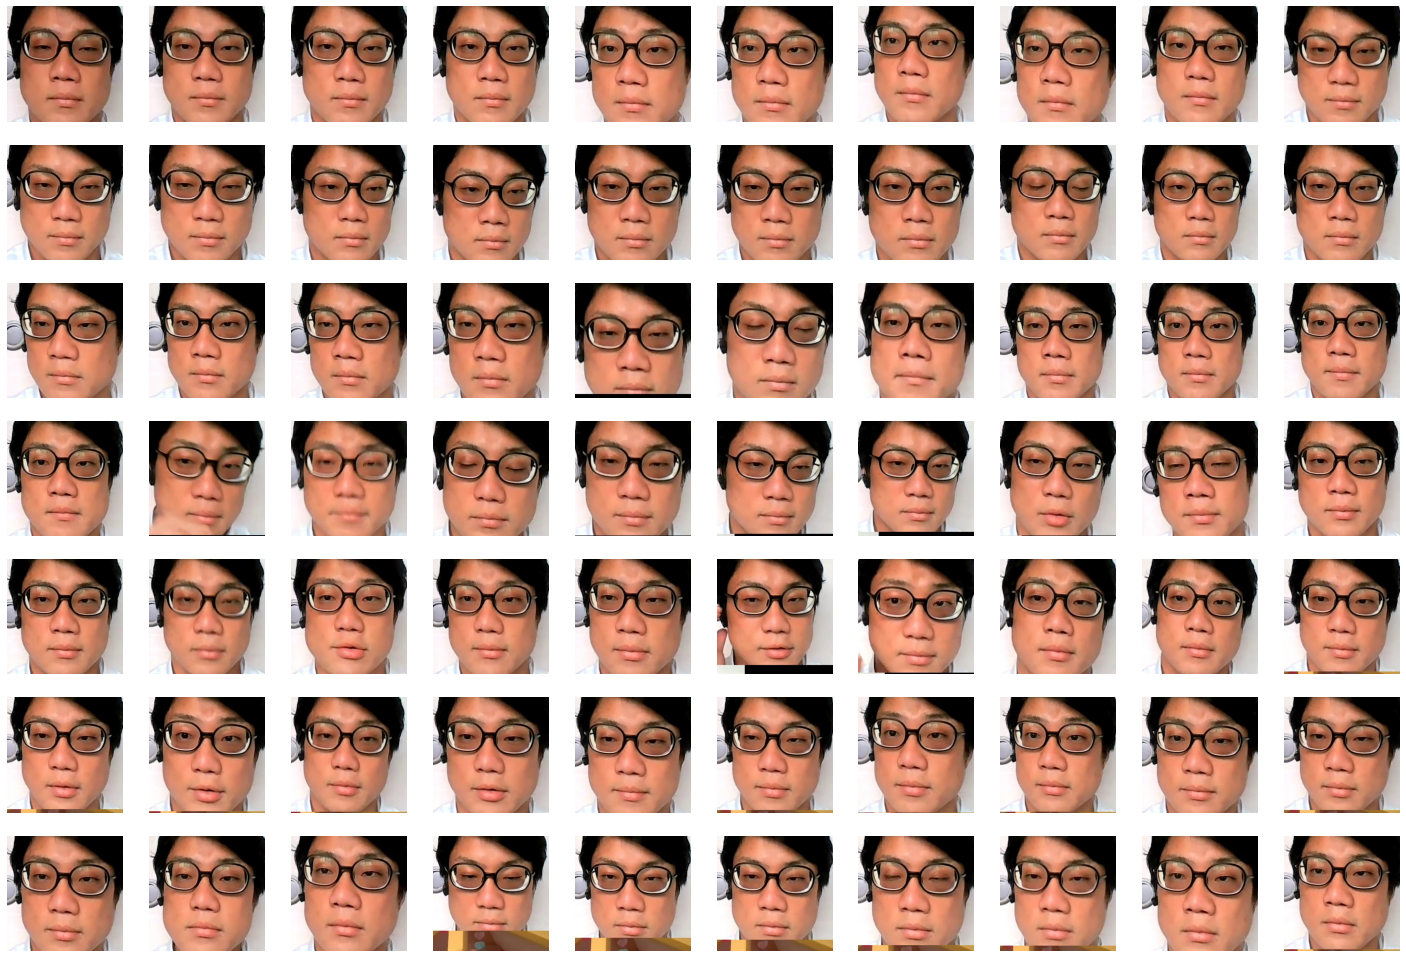

In [150]:
view_cluster(0)

Clipping cluster size from 10541 to 100


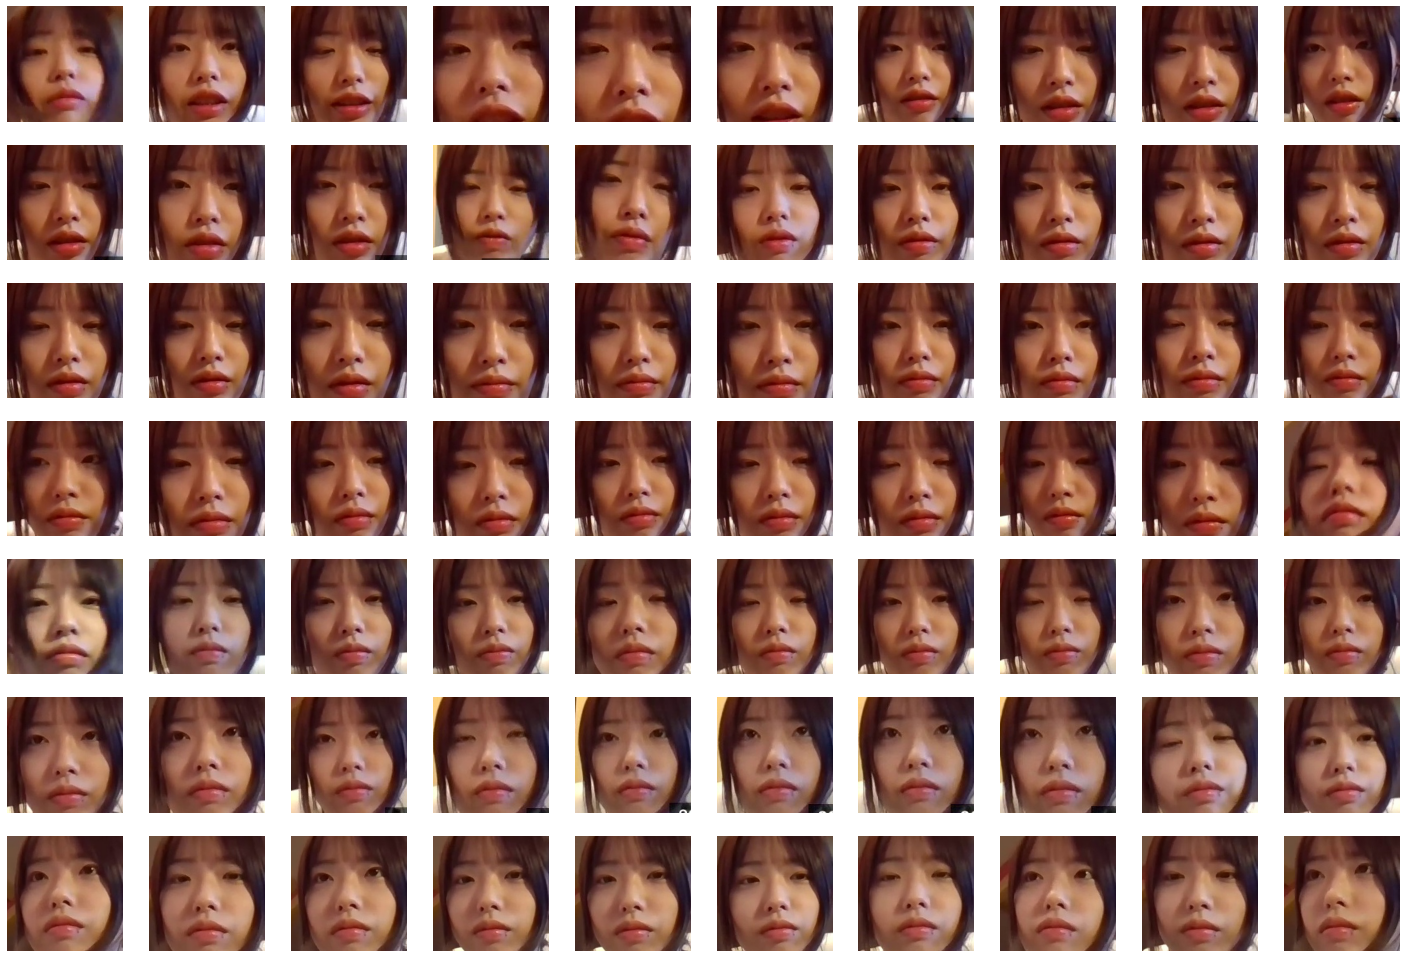

In [151]:
view_cluster(1)

Clipping cluster size from 6004 to 100


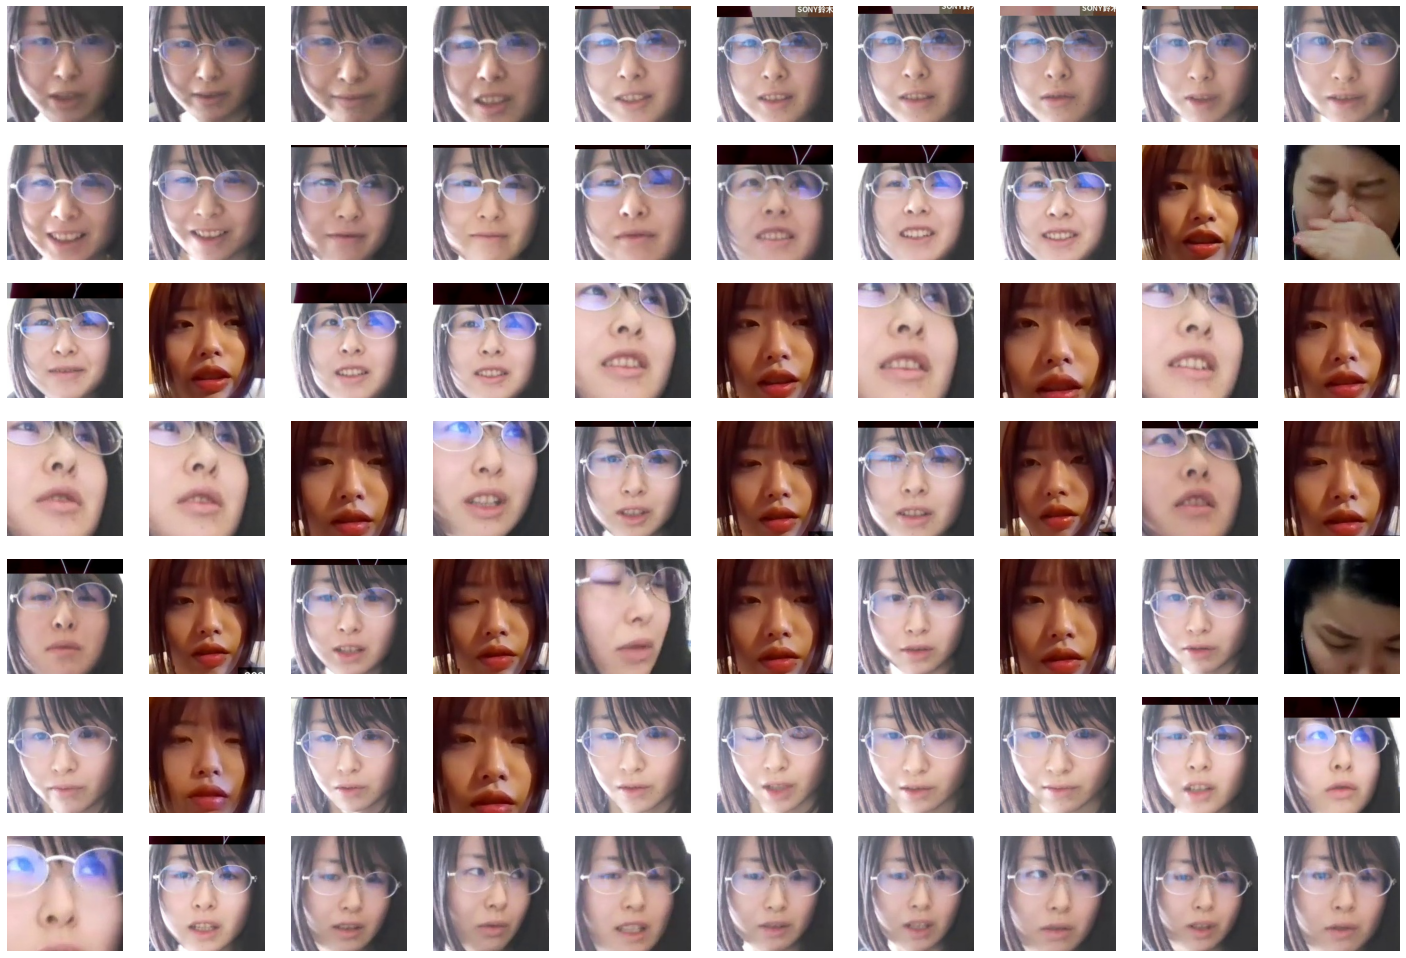

In [152]:
view_cluster(2)

Clipping cluster size from 8817 to 100


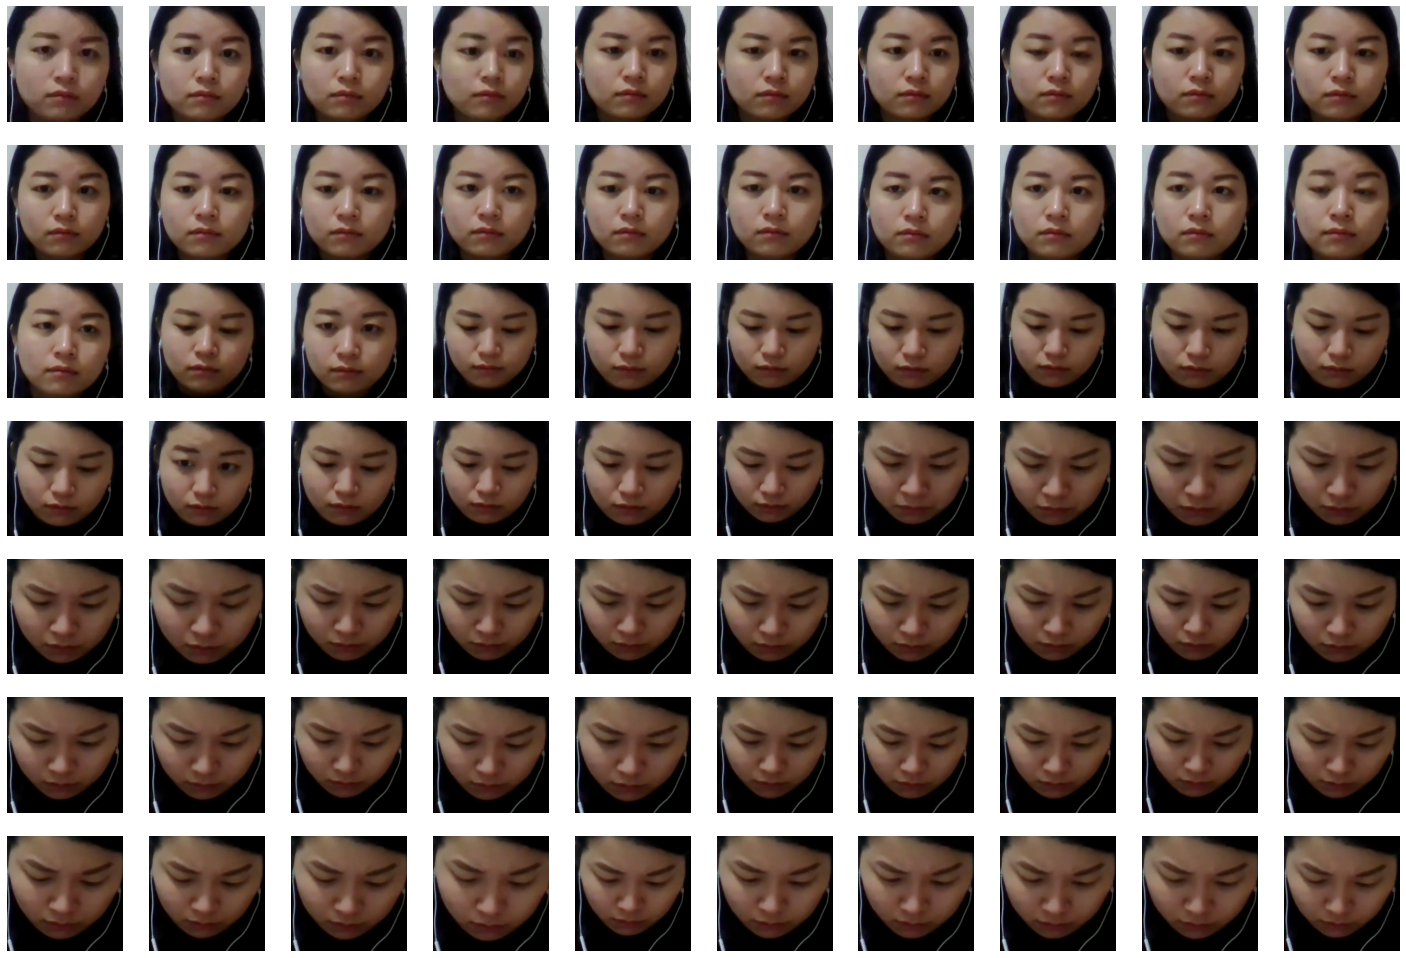

In [153]:
view_cluster(3)

# By reference to the images and the excel file we can predict that the clusters are 
# ID->cluster, 
# 1->3 ,
# 4->0 , 
# 3->2 , 
# 2->1

In [58]:
y_pred=[]

In [ ]:
for i in range (len(kmeans.predict(x))):
    print(i)
    if kmeans.predict(x)[i]==3:
        y_pred.append(1.0)
        continue
    elif kmeans.predict(x)[i]==0:
        y_pred.append(4.0)
        continue
    elif kmeans.predict(x)[i]==2:
        y_pred.append(3.0)
        continue
    elif kmeans.predict(x)[i]==1:
        y_pred.append(2.0)
        continue

In [91]:
y_pred=np.array(y_pred)

In [117]:
y_test=df["ID"].to_numpy()
y_test= y_test.astype('float64')

In [119]:
metrics.accuracy_score(y_test,y_pred)

0.9033641380227379

In [125]:
f1_score(y_test,y_pred, average='weighted')

0.9003582031604779